In [8]:
!pip install tensorflow numpy pandas opencv-python matplotlib scikit-learn kagglehub

In [9]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, GlobalAveragePooling2D,Lambda,BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [10]:
import kagglehub
path = kagglehub.dataset_download("tejasreddy/iam-handwriting-top50")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/iam-handwriting-top50


In [11]:
image_dir = '/kaggle/input/iam-handwriting-top50/data_subset/data_subset'
txt_path = '/kaggle/input/iam-handwriting-top50/forms_for_parsing.txt'

In [12]:
def preprocess_image(image_path, target_size=(224,224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = preprocess_input(img.astype(np.float32))
    return img

In [13]:
form_writer_map = {}
with open(txt_path, 'r') as f:
    for line in f:
        if line.strip():
            parts = line.strip().split()
            if len(parts) >= 2:
                form_id, writer_id = parts[0], parts[1]
                form_writer_map[form_id] = writer_id

In [7]:
data, labels = [], []
for fname in tqdm(os.listdir(image_dir)):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        form_id = os.path.splitext(fname)[0].split("-s")[0]
        if form_id in form_writer_map:
            label = form_writer_map[form_id]
            img_path = os.path.join(image_dir, fname)
            img = preprocess_image(img_path)
            data.append(img)
            labels.append(label)
X = np.array(data)
y = np.array(labels)

100%|██████████| 4899/4899 [00:41<00:00, 117.36it/s]


In [14]:
from collections import Counter
label_counts = Counter(labels)
top_writers = [writer for writer, count in label_counts.most_common(10)]

filtered_data = []
filtered_labels = []
for img, label in zip(data, labels):
    if label in top_writers:
        filtered_data.append(img)
        filtered_labels.append(label)

X = np.array(filtered_data)
y = np.array(filtered_labels)

In [15]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

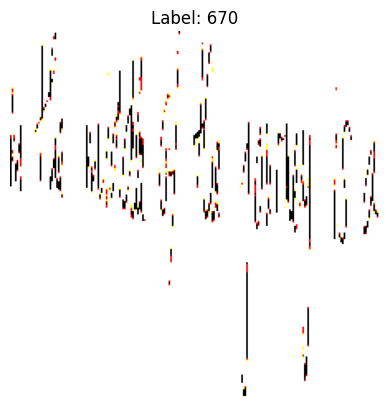

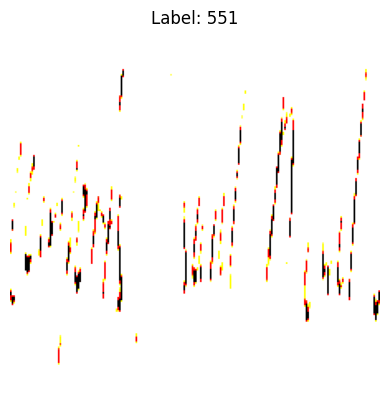

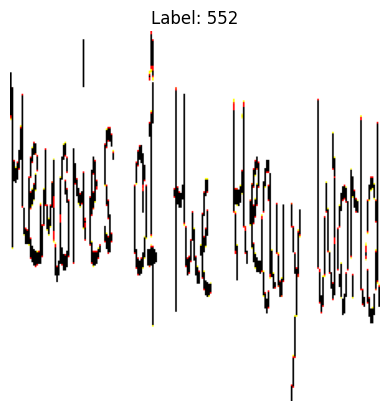

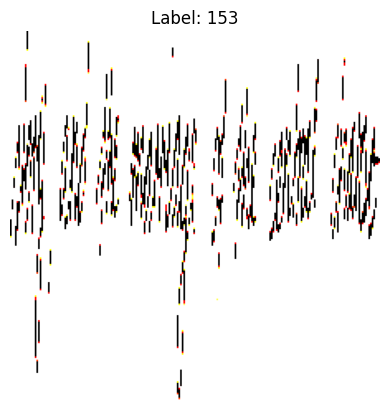

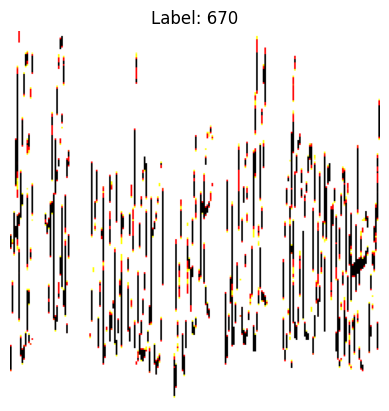

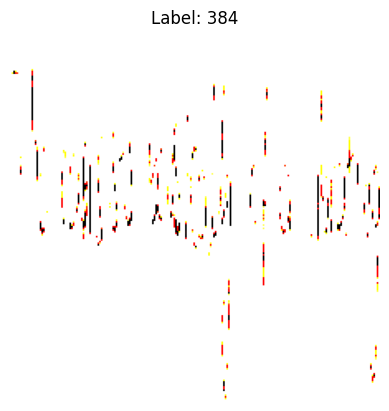

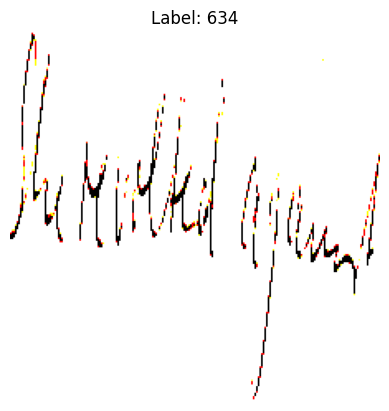

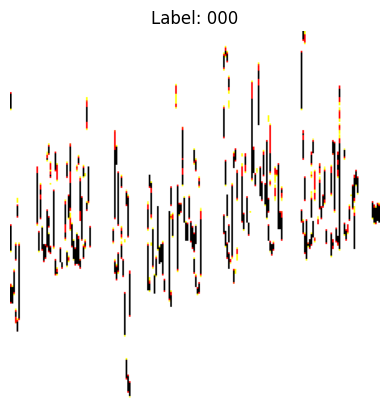

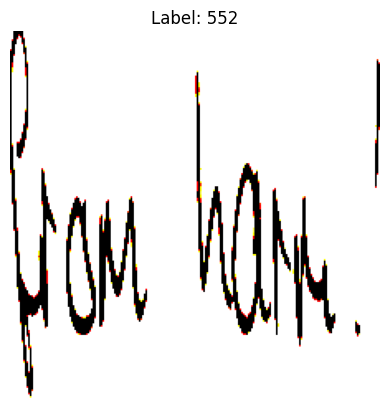

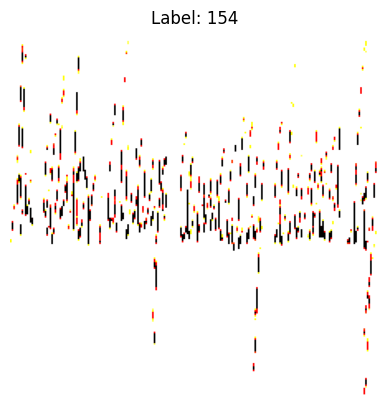

In [17]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    label = le.inverse_transform([np.argmax(y_train[i])])[0]
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(le.classes_), activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 383ms/step - accuracy: 0.4446 - loss: 1.8405 - val_accuracy: 0.7827 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7313 - loss: 0.7936 - val_accuracy: 0.8914 - val_loss: 0.3952 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8180 - loss: 0.5350 - val_accuracy: 0.9164 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8611 - loss: 0.3947 - val_accuracy: 0.9248 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8976 - loss: 0.3119 - val_accuracy: 0.9192 - val_loss: 0.2476 - learning_rate: 0.0010
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9065 - loss: 0.2968 - val_accuracy: 0.9359 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9064 - loss: 0.2775 -

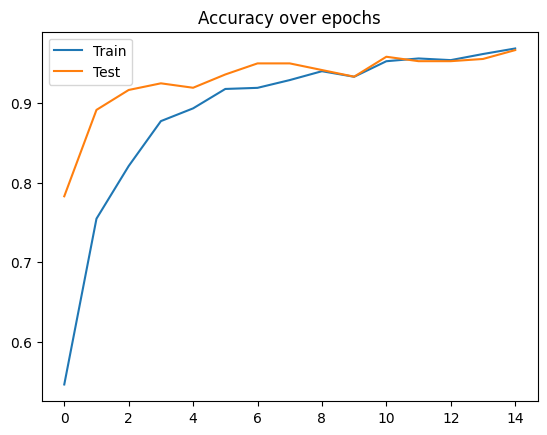

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

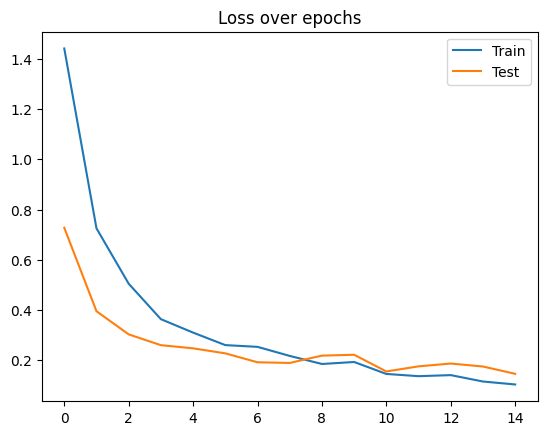

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [22]:
resnet_model.save("/kaggle/resnet_model.keras")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 393ms/step


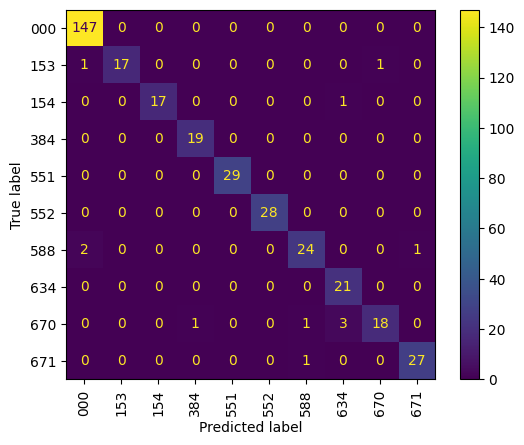

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = resnet_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap='viridis', xticks_rotation=90)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


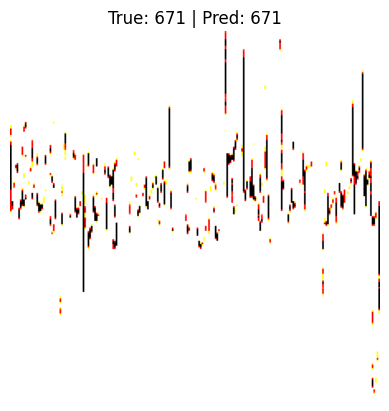

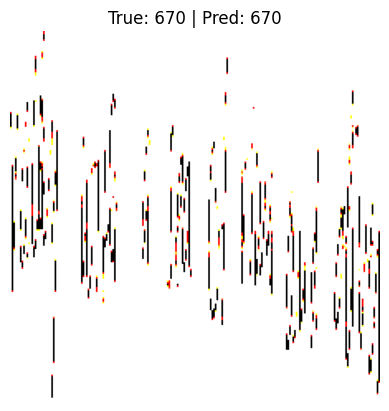

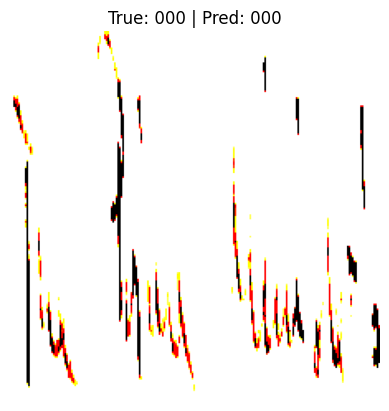

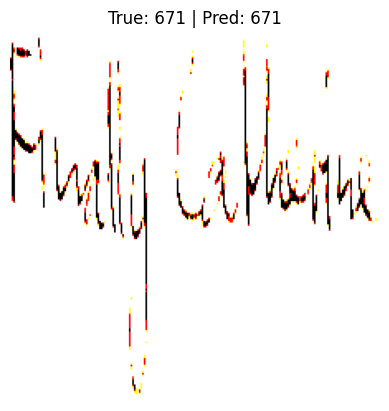

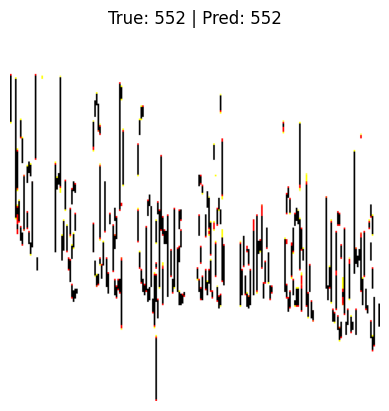

In [24]:
preds = resnet_model.predict(X_test)
for i in range(5):
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    true_label = le.inverse_transform([np.argmax(y_test[i])])[0]
    pred_label = le.inverse_transform([np.argmax(preds[i])])[0]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()